# Foreign Keys

# Modeling Relationships with Foreign Keys

While **entity integrity** ensures that each record uniquely represents a real-world entity, **referential integrity** ensures that the *relationships between* these entities are valid and consistent. It's a guarantee that you won't have an employee assigned to a non-existent department or a task associated with a deleted project.

Crucially, **referential integrity is impossible without entity integrity**. You must first have a reliable way to identify unique entities before you can define their relationships.

In relational databases, these relationships are established and enforced using **foreign keys**. A foreign key creates a link between a **child table** (the one with the reference) and a **parent table** (the one being referenced). Think of `Employee` as the child and `Title` as the parent; an employee must have a valid, existing title.

A foreign key is a column (or set of columns) in the child table that refers to the primary key of the parent table. In DataJoint, a foreign key *always* references a parent's primary key, which is a highly recommended practice for clarity and consistency.

In the following example, we define the parent table `Title` and the child table `Employee`, which references `Title`.

In [9]:
%xmode Minimal

import datajoint as dj
schema = dj.Schema('company')


@schema
class Title(dj.Lookup):
    definition = """
    title_code  : char(8)
    ---
    full_title : varchar(120)
    """
    
    contents = [
        ("SW-Dev1", "Software Developer 1"),
        ("SW-Dev2", "Software Developer 2"),
        ("SW-Dev3", "Software Developer 3"),
        ("Web-Dev1", "Web Developer 1"),
        ("Web-Dev2", "Web Developer 2"),
        ("Web-Dev3", "Web Developer 3"),
        ("HR-Mgr", "Human Resources Manager")
    ]

@schema
class Employee(dj.Manual):
    definition = """
    person_id  :  int 
    ---
    first_name : varchar(30)
    last_name : varchar(30)
    -> Title
    """

Exception reporting mode: Minimal


Here the arrow `-> Title` creates a foreign key from `Employee` (child) to `Title` (parent).

We can use the `dj.Diagram` class to visualize the relationships created by the foreign keys.

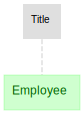

In [4]:
dj.Diagram(schema)

The parent table `Title` is above and the child table `Employee` is below.

## Defining Foreign Keys in SQL
In standard SQL, the same relationship is defined with more verbose syntax. The child table must explicitly redefine the columns of the parent's primary key and then declare the foreign key constraint.

Notice that the data type (`char(8)`) of the primary key in `Title` must be exactly repeated for the `title_code` column in `Employee`.

```sql
-- Parent Table
CREATE TABLE title (
    title_code  CHAR(8) NOT NULL,
    full_title  VARCHAR(120) NOT NULL,
    PRIMARY KEY (title_code)
);

-- Child Table
CREATE TABLE employee (
person_id   INT NOT NULL,
first_name  VARCHAR(30) NOT NULL,
last_name   VARCHAR(30) NOT NULL,
title_code  CHAR(8) NOT NULL,
PRIMARY KEY (person_id),
FOREIGN KEY (title_code) REFERENCES title(title_code)
);
```

The concise `-> Title` syntax in DataJoint handles this automatically, reducing redundancy and preventing potential errors if the parent's primary key definition changes.

```{admonition} A Logical Constraint, not a Physical Pointer
:class: tip

A revolutionary concept in the relational model is that a foreign key is **not a physical pointer** to a location on a disk. Instead, it is a **logical constraint** enforced at runtime.

When you try to insert a row into a child table, the database doesn't follow a pre-existing "link." It performs a search on the parent table to see if a record with a matching primary key exists. If a match is found, the insert is allowed; otherwise, it is rejected.

This is fundamentally different from other data models like HDF5, where data is often linked by direct pointers or paths [^1]. The logical nature of foreign keys gives relational databases their flexibility and integrity.

[^1]: The HDF Group. "HDF5 User's Guide: Groups and Links". [https://docs.hdfgroup.org/hdf5/develop/H5.intro.html#intro-groups](https://docs.hdfgroup.org/hdf5/develop/H5.intro.html#intro-groups)
```

## The Five Effects of a Foreign Key

Foreign keys enforce **referential integrity** by regulating the relationships between a **parent table** (referenced entity set) and a **child table** (dependent entity set). In addition to defining how entities relate, foreign keys also impose important constraints on data operations. 

Below are the five key effects of foreign keys:

### Effect 1. The primary key columns from the parent become embedded as foreign key columns in the child  
When a foreign key relationship is established, the **primary key** (or unique key) of the parent table becomes part of the child table’s schema. The child table includes the foreign key attribute(s) with **matching name and datatype** to ensure that each row in the child table refers to a valid parent record.

If you examine the heading of `Employee`, you will find that it now contains a `title_code` field. It will have the same data type as the 


In [5]:
Employee()

person_id,first_name,last_name,title_code


### Effect 2: Inserts into the Child Table are Restricted

A foreign key ensures that no "orphaned" records are created. An insert into the child table is only permitted if the foreign key value corresponds to an existing primary key in the parent table.

The rule is simple: **Inserts are restricted in the child, not the parent.** You can always add new job titles, but you cannot add an employee with a `title_code` that doesn't exist in the `Title` table.

In [6]:
# This works!
Employee.insert1((1, 'Mark', 'Sommers', 'Web-Dev1'))

In [7]:
# This fails!
Employee.insert1((2, 'Brenda', 'Means', 'BizDev'))

IntegrityError: Cannot add or update a child row: a foreign key constraint fails (`company`.`employee`, CONSTRAINT `employee_ibfk_1` FOREIGN KEY (`title_code`) REFERENCES `#title` (`title_code`) ON DELETE RESTRICT ON UPDATE CASCADE)

### Effect 3: Deletes from the Parent Table are Restricted

To prevent broken relationships, a parent record cannot be deleted if any child records still refer to it.

The rule is the inverse of the insert rule: **Deletes are restricted in the parent, not the child.** You can always delete an employee, but you cannot delete a title if it is still assigned to an employee.

In standard SQL, this operation would fail with a constraint error. DataJoint, however, implements a **cascading delete**. It will warn you that deleting the parent record will also delete all dependent child records, which can cascade through many levels of a deep hierarchy.

In [8]:
Title.delete()

[2025-09-18 14:31:21,418][INFO]: Deleting 1 rows from `company`.`employee`
[2025-09-18 14:31:21,422][INFO]: Deleting 7 rows from `company`.`#title`
[2025-09-18 14:31:29,056][WARNING]: Delete cancelled


7

### Effect 4: Updates to Referenced Keys are Restricted

To maintain referential integrity, updates to a parent's primary key or a child's foreign key are restricted.

In general relational theory, databases can be configured to handle this with **cascading updates**, where changing a parent's primary key automatically propagates that change to all child records.

However, DataJoint does not support updating primary key values, as this can risk breaking referential integrity in complex scientific workflows. The preferred and safer pattern in DataJoint is to **delete the old record and insert a new one** with the updated information.

# Summary

Foreign keys ensure referential integrity by linking a child table to a parent table. This link imposes five key effects:

1.  **Schema Embedding**: The parent's primary key is added as columns to the child table.
2.  **Insert Restriction**: A row cannot be added to the **child** if its foreign key doesn't match a primary key in the **parent**.
3.  **Delete Restriction**: A row cannot be deleted from the **parent** if it is still referenced by any rows in the **child**.
4.  **Update Restriction**: Updates to the primary and foreign keys are restricted to prevent inconsistencies.
5.  **Performance Optimization**: An index is automatically created on the foreign key in the child table to speed up searches and joins.